# Laboratorium - Deep Double Descent

In [1]:
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


2025-04-25 16:05:18.159875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# GLOBALS

seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [4]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


### Wczytanie i przetworzenie danych MNIST

- Spłaszczenie i normalizacja obrazów.
- Losowy wybór 5000 próbek treningowych.
- One-hot encoding etykiet.


In [5]:
train_X = train_X.reshape(-1, 28 * 28).astype("float32") / 255.0
test_X = test_X.reshape(-1, 28 * 28).astype("float32") / 255.0

train_X, _, train_y, _ = train_test_split(train_X, train_y, train_size=5000, stratify=train_y, random_state=seed)

train_y_oh = to_categorical(train_y, 10)
test_y_oh = to_categorical(test_y, 10)

(train_X.shape, train_y_oh.shape), (test_X.shape, test_y_oh.shape)

(((5000, 784), (5000, 10)), ((10000, 784), (10000, 10)))

### Przygotowanie trzech architektur MLP

Tworzymy trzy klasy sieci MLP o rosnącej liczbie parametrów:
- mała: liczba parametrów < liczba próbek,
- średnia: liczba parametrów ≈ liczba próbek,
- duża: liczba parametrów ≫ liczba próbek.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import HeNormal

def create_mlp(input_dim, output_dim, hidden_layers, hidden_units, seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

    model = Sequential()
    model.add(Dense(hidden_units, input_dim=input_dim, activation='relu',
                    kernel_initializer=HeNormal(seed=seed), name="dense_hidden_0"))
    for i in range(1, hidden_layers):
        model.add(Dense(hidden_units, activation='relu',
                        kernel_initializer=HeNormal(seed=seed + i), name=f"dense_hidden_{i}"))
    model.add(Dense(output_dim, activation='softmax', name="output"))
    return model

small_model = create_mlp(784, 10, hidden_layers=2, hidden_units=32)
medium_model = create_mlp(784, 10, hidden_layers=2, hidden_units=128)
large_model = create_mlp(784, 10, hidden_layers=2, hidden_units=512)


2025-04-25 16:05:20.056309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Funkcja do wyznaczania liczby neuronów na warstwę

Przy ustalonej liczbie parametrów i liczbie warstw obliczamy ile neuronów może mieć każda warstwa.


In [7]:
def compute_hidden_size(target_params, input_dim=784, output_dim=10, hidden_layers=1):
    for h in range(1, 1000):
        total_params = input_dim * h + (hidden_layers - 1) * h * h + h * output_dim + hidden_layers + output_dim
        if total_params > target_params:
            return h - 1
    return None


In [8]:
import sys
def clear_output_line(n = 1) :
    sys.stdout.write(f'\x1b[{n}A')
    sys.stdout.write('\x1b[2K')
    if n > 1 : sys.stdout.write('\x1b[2B')
    sys.stdout.flush()

### Funkcja treningu i ewaluacji

Trenujemy model 3 razy, zwracamy średnie metryki: Accuracy i F1-score (macro).


In [9]:
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.optimizers import Adam

def train_and_evaluate(create_model_fn, X_train, y_train, X_test, y_test, runs=3, epochs=10, batch_size=32):
    accs = []
    f1s = []
    
    for _ in range(runs):
        model = create_model_fn()
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=None)

        preds = model.predict(X_test, verbose = 0)
        y_pred = np.argmax(preds, axis=1)
        y_true = np.argmax(y_test, axis=1)

        accs.append(accuracy_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred, average='macro'))

    return np.mean(accs), np.mean(f1s)


### Funkcja zaszumiania etykiet

Zmieniamy procent etykiet treningowych na losowe inne klasy.

In [10]:
def add_label_noise(y, noise_level=0.2, num_classes=10, seed=42): 
    np.random.seed(seed)
    y_noisy = np.array(y)

    n_samples = len(y)
    n_noisy = int(noise_level * n_samples)
    noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)

    for idx in noisy_indices:
        current_label = np.argmax(y_noisy[idx])
        new_label = np.random.choice([i for i in range(num_classes) if i != current_label])
        y_noisy[idx] = np.eye(num_classes)[new_label]

    return y_noisy



### Uniwersalna funkcja do rysowania wykresów

Łączymy rysowanie metryk (Accuracy/F1) oraz saturacji w jedną funkcję z parametrem trybu działania.

In [11]:
def plot_experiment(data: dict, kind: str, metric: str = None, title: str = "", ylabel: str = "", suffix: str = ""):
    plt.figure(figsize=(10, 4))
    
    if kind == "metric":
        for name, values in data.items():
            label = f"{name} model{suffix}"
            plt.plot(values["layers"], values[metric], marker='o', label=label)
        plt.xlabel("Number of Hidden Layers")
    
    elif kind == "saturation":
        for n_layers, values in data.items():
            plt.plot(range(1, len(values)+1), values, marker='o', label=f'{n_layers} layers')
        plt.xlabel("Number of hidden layer")
    
    else:
        raise ValueError("kind must be 'metric' or 'saturation'")
    
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Zadanie 1

Cel: Zbadać wpływ liczby warstw na skuteczność modelu przy stałej liczbie parametrów.

Plan:
1. Dla małej, średniej i dużej sieci testujemy różną liczbę warstw (1–8).
2. Dla każdej konfiguracji dopasowujemy liczbę neuronów, by zachować ~stałą liczbę parametrów.
3. Obliczamy średnie Accuracy i F1-score (3 powtórzenia).
4. Analizujemy spadek jakości i korelację metryk.

Sieci :  
 - small - 2 000 param  
 - medium - 5 000 param  
 - large - 10 000 param  

In [12]:

param_configs = {
    "small": 2_000,
    "medium": 5_000,
    "large": 10_000
}

def experiment_1() :

    results = {}

    for name, total_params in param_configs.items():
        results[name] = {"layers": [], "acc": [], "f1": []}
        for n_layers in range(1, 16):
            hidden_units = compute_hidden_size(total_params, hidden_layers=n_layers)
            if hidden_units is None:
                continue

            def make_model():
                return create_mlp(input_dim=784, output_dim=10, hidden_layers=n_layers, hidden_units=hidden_units)
            acc, f1 = train_and_evaluate(make_model, train_X, train_y_oh, test_X, test_y_oh)
            results[name]["layers"].append(n_layers)
            results[name]["acc"].append(acc)
            results[name]["f1"].append(f1)

            # print(f"{name} | layers: {n_layers}, units/layer: {hidden_units}, acc: {acc:.4f}, f1: {f1:.4f}")

    plot_experiment(results, kind="metric", metric="acc", title="Accuracy vs Number of Layers", ylabel="Accuracy")

    plot_experiment(results, kind="metric", metric="f1", title="F1-score vs Number of Layers", ylabel="F1-score (macro)")


    return results

### Wizualizacja wyników

Tworzymy wykresy Accuracy i F1-score jako funkcje liczby warstw dla trzech złożoności modelu.


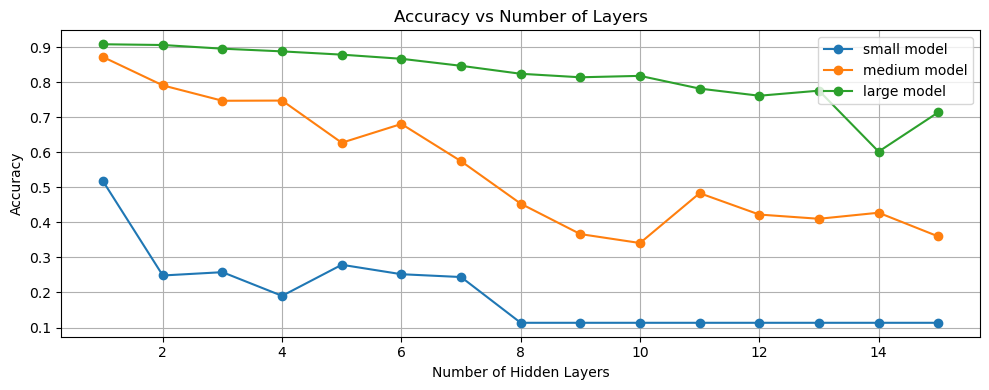

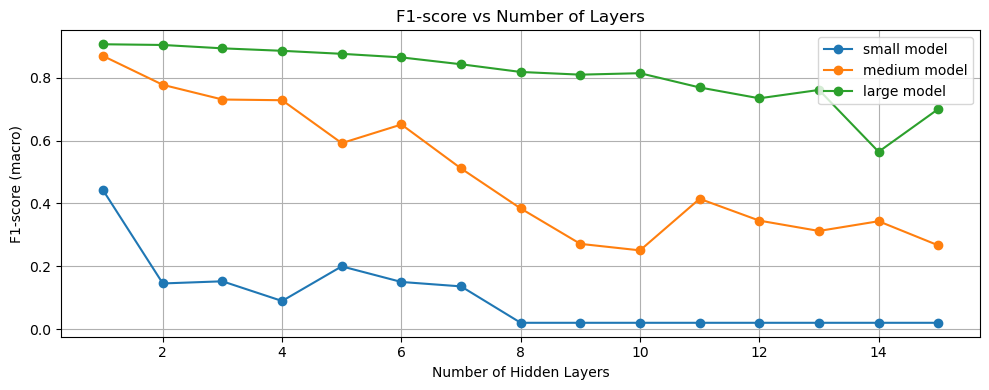

In [13]:
results = experiment_1()

### Wnioski – wpływ liczby warstw na skuteczność modelu

1. Zwiększanie liczby warstw przy stałej liczbie parametrów obniża jakość modelu (zarówno Accuracy, jak i F1-score).
2. Modele z dużą liczbą parametrów są bardziej odporne na spadek jakości, podczas gdy małe modele szybko tracą skuteczność przy większej głębokości.
3. F1-score i Accuracy są silnie skorelowane, ponieważ dane są zbalansowane i model zachowuje podobną skuteczność predykcji dla wszystkich klas.


## Zadanie 2

Cel: Zrozumieć spadek jakości przy zwiększaniu liczby warstw (przy stałej liczbie parametrów).

Plan:
1. Obliczyć saturację warstw (np. % neuronów z zerową aktywacją dla ReLU).
2. Porównać saturację w sieciach o różnej liczbie warstw.
3. Wysnuć hipotezę: czy degradacja wynika z zaniku sygnału?
4. Zasugerować architektoniczne poprawki (BatchNorm, inne aktywacje).


### Obliczanie saturacji warstw

Zbieramy aktywacje z każdej warstwy ukrytej i liczymy % neuronów, które mają wyłącznie zerowe aktywacje (dla ReLU).


In [14]:
from tensorflow.keras.models import Model

def compute_layer_saturation(model, X, layer_names=None):
    if layer_names is None:
        layer_names = [layer.name for layer in model.layers if isinstance(layer, Dense) and layer.activation.__name__ == "relu"]
    
    activations = Model(inputs=model.input, outputs=[model.get_layer(name).output for name in layer_names]).predict(X, verbose=None)
    
    saturation = {}
    for name, act in zip(layer_names, activations):
        dead_neurons = np.all(act == 0, axis=0)
        saturation[name] = 100 * np.sum(dead_neurons) / len(dead_neurons)

    return saturation


### Przykład: saturacja w sieci 2-warstwowej

Trenujemy model z 2 warstwami ukrytymi i sprawdzamy saturację każdej z nich.


In [15]:
target_params = 5000
hidden_layers = 2
hidden_units = compute_hidden_size(target_params, hidden_layers=hidden_layers)

model = create_mlp(input_dim=784, output_dim=10, hidden_layers=hidden_layers, hidden_units=hidden_units)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_X, train_y_oh, epochs=10, batch_size=32, verbose=None)

saturation = compute_layer_saturation(model, test_X)

for layer, perc in saturation.items():
    print(f"{layer}: {perc:.2f}% dead neurons")


dense_hidden_0: 16.67% dead neurons
dense_hidden_1: 16.67% dead neurons


### Eksperyment: saturacja a liczba warstw

Dla modeli z 2–8 warstwami ukrytymi (przy tej samej liczbie parametrów) obliczamy saturację i tworzymy wykres porównawczy.


In [16]:
def experiment_2() :
    saturation_results = {}
    target_params = 5000

    for n_layers in range(2, 9):
        hidden_units = compute_hidden_size(target_params, hidden_layers=n_layers)
        if hidden_units is None:
            continue

        model = create_mlp(input_dim=784, output_dim=10, hidden_layers=n_layers, hidden_units=hidden_units)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(train_X, train_y_oh, epochs=10, batch_size=32, verbose=None)

        sats = compute_layer_saturation(model, test_X)
        saturation_results[n_layers] = list(sats.values())

    plot_experiment(saturation_results, kind="saturation", title="Layer saturation vs number of layers (const num of parameters)", ylabel="% of dead neurons")

    return saturation_results

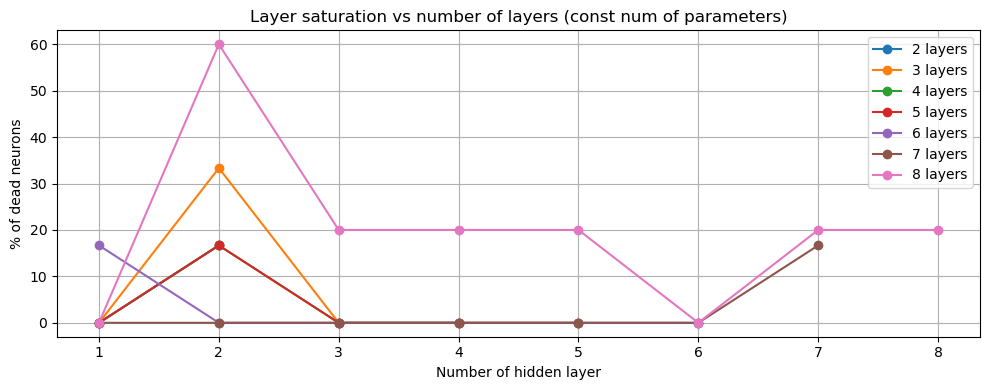

In [17]:
saturation_results = experiment_2()

### Wnioski – saturacja a liczba warstw

1. Najwyższy poziom saturacji obserwujemy w sieciach 7–8 warstwowych, zwłaszcza w ich początkowych warstwach.
2. Dla sieci 3–5 warstwowych saturacja pojawia się punktowo (głównie w 2. warstwie), ale nie rośnie w kolejnych warstwach.
3. Saturacja nie występuje liniowo – może zależeć od interakcji między warstwami, a nie tylko głębokości.
4. Głębsze sieci (przy tej samej liczbie parametrów) są trudniejsze do nauki i podatne na zanik aktywacji, co może tłumaczyć spadek jakości.

### Zadanie 3 – wpływ zaszumionych etykiet

Cel: Sprawdzić wpływ szumu etykiet (np. 20%) na jakość modeli o różnej złożoności i liczbie warstw.

Plan:
1. Zaszumiamy 20% etykiet w zbiorze treningowym.
2. Powtarzamy eksperyment z zadania 1 (różne liczby warstw, stała liczba parametrów).
3. Zbieramy Accuracy i F1-score (średnie z 3 prób).
4. Tworzymy wykresy i porównujemy z wersją bez szumu.


In [18]:
def experiment_3() :
    noisy_results = {}
    noise_level = 0.2

    train_y_noisy = add_label_noise(train_y_oh, noise_level=noise_level)

    for name, total_params in param_configs.items():
        noisy_results[name] = {"layers": [], "acc": [], "f1": []}
        for n_layers in range(1, 16):
            hidden_units = compute_hidden_size(total_params, hidden_layers=n_layers)
            if hidden_units is None:
                continue

            def make_model():
                return create_mlp(input_dim=784, output_dim=10, hidden_layers=n_layers, hidden_units=hidden_units)

            acc, f1 = train_and_evaluate(make_model, train_X, train_y_noisy, test_X, test_y_oh)
            noisy_results[name]["layers"].append(n_layers)
            noisy_results[name]["acc"].append(acc)
            noisy_results[name]["f1"].append(f1)

            # print(f"[NOISY] {name} | layers: {n_layers}, acc: {acc:.4f}, f1: {f1:.4f}")

    plot_experiment(noisy_results, kind="metric", metric="acc", title="Accuracy vs Number of Layers (noisy labels)", ylabel="Accuracy", suffix=" (noisy)")

    plot_experiment(noisy_results, kind="metric", metric="f1", title="F1-score vs Number of Layers (noisy labels)", ylabel="F1-score (macro)", suffix=" (noisy)")

    return noisy_results


### Wykresy – wpływ szumu na skuteczność modeli

Tworzymy wykresy Accuracy i F1-score w zależności od liczby warstw dla modeli uczonych na zaszumionych etykietach.


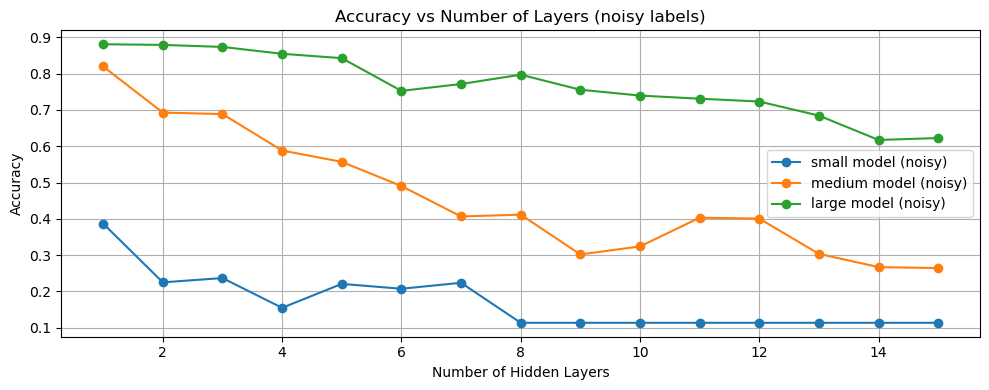

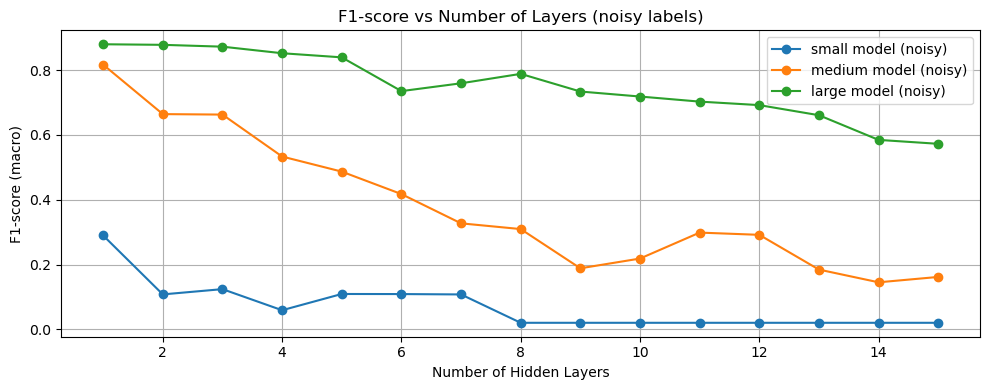

In [19]:
noisy_results = experiment_3()

### Wnioski – wpływ szumu etykiet na modele o różnej złożoności

1. Dodanie szumu do etykiet pogarsza wyniki wszystkich modeli, ale w różnym stopniu.
2. Modele o małej złożoności (small) tracą zdolność generalizacji już przy kilku warstwach – F1 spada niemal do zera.
3. Modele średnie i duże (medium, large) są bardziej odporne, ale również zaczynają przetrenowywać – pojawia się efekt overfittingu na szum.
4. Widoczny jest efekt podobny do **deep double descent** – dla modeli large przy większej liczbie warstw pojawia się lokalne pogorszenie i poprawa F1, typowe dla tego zjawiska.
5. Szum ujawnia ograniczenia architektury – zwiększenie liczby warstw przy szumie nasila problemy z uczeniem i generalizacją.


### Wykres porównawczy: wersja z szumem vs bez szumu

Tworzymy wykres porównawczy dla Accuracy i F1-score, porównując modele z szumem i bez szumu w etykietach.


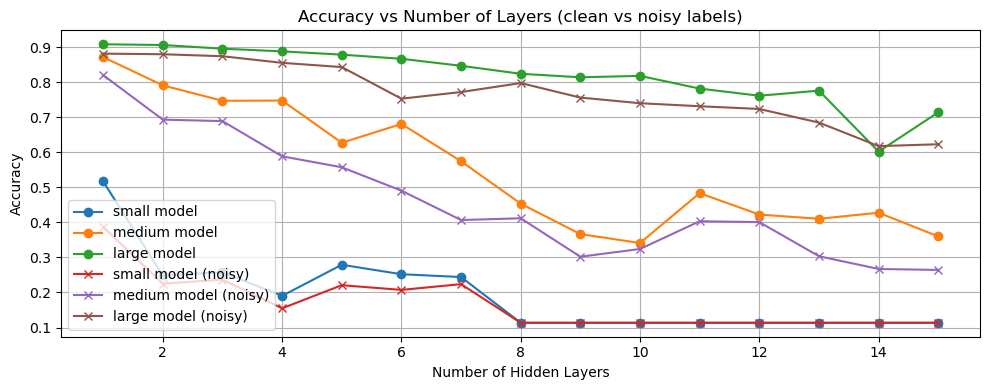

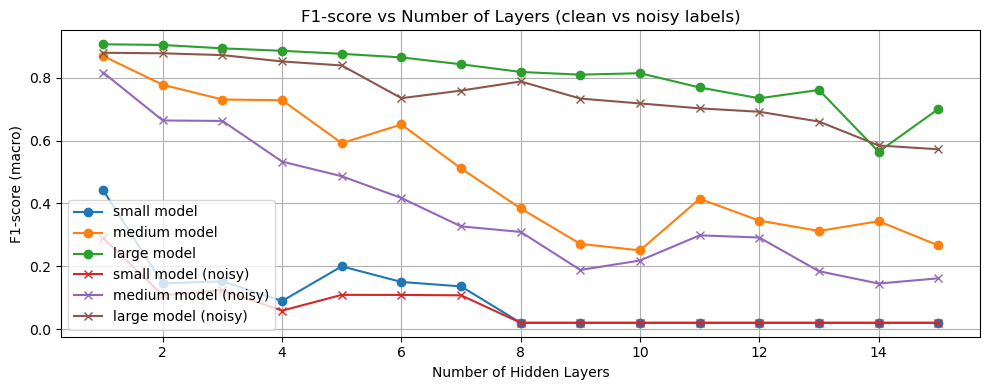

In [20]:
plt.figure(figsize=(10, 4))
for name in results:
    plt.plot(results[name]["layers"], results[name]["acc"], marker='o', label=f"{name} model")
for name in noisy_results:
    plt.plot(noisy_results[name]["layers"], noisy_results[name]["acc"], marker='x', label=f"{name} model (noisy)")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Layers (clean vs noisy labels)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for name in results:
    plt.plot(results[name]["layers"], results[name]["f1"], marker='o', label=f"{name} model")
for name in noisy_results:
    plt.plot(noisy_results[name]["layers"], noisy_results[name]["f1"], marker='x', label=f"{name} model (noisy)")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("F1-score (macro)")
plt.title("F1-score vs Number of Layers (clean vs noisy labels)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Wnioski końcowe

1. **Zwiększanie liczby warstw przy stałej liczbie parametrów** prowadzi do spadku jakości modeli. W szczególności, głębsze sieci o małej liczbie neuronów w każdej warstwie stają się mniej efektywne, ponieważ **saturacja warstw** (czyli procent neuronów z zerową aktywacją) rośnie z każdą dodatnią warstwą. Neurony w głębszych warstwach zaczynają stawać się nieaktywne, co skutkuje brakiem wystarczającej liczby aktywnych jednostek do reprezentacji danych. Zjawisko to powoduje problemy z propagacją sygnałów, a sieć staje się trudniejsza do trenowania. Z tego powodu większa liczba warstw w modelach o małej liczbie neuronów skutkuje **degradacją wyników**.

2. **Saturacja warstw** jest jednym z głównych problemów w głębszych sieciach. W miarę jak zwiększa się liczba warstw przy stałej liczbie parametrów, sieć staje się coraz mniej efektywna. To dlatego sieci o dużej liczbie warstw, ale niewielkiej liczbie neuronów w każdej warstwie, często napotykają problemy, takie jak **zanikanie aktywacji**. Większa liczba warstw wymaga większej liczby neuronów, aby uniknąć zaniku gradientu. Można poprawić tę sytuację, stosując **Batch Normalization**, inne funkcje aktywacji (np. LeakyReLU lub GELU), a także odpowiednią inicjalizację wag, aby zapobiec problemom z propagowaniem sygnałów w głębszych sieciach.

3. **Deep Double Descent** jest zjawiskiem, które występuje w modelach o większej liczbie parametrów. W początkowej fazie, gdy liczba warstw rośnie, model traci na jakości, ale po pewnym punkcie (przypadek dużych sieci) jego wyniki zaczynają się poprawiać. Jest to charakterystyczne dla **deep double descent**, gdzie model najpierw przechodzi przez etap przeuczenia, a następnie, przy odpowiedniej liczbie warstw, zaczyna lepiej generalizować. Większe modele z większą liczbą parametrów są w stanie skutecznie **rozwiązywać bardziej złożone problemy**. Należy jednak pamiętać, że im większa sieć, tym większe ryzyko przeuczenia, dlatego warto zastosować odpowiednie metody regularyzacji, takie jak **dropout** czy **L2 regularization**, aby zapobiec nadmiernemu dopasowaniu do danych.

4. **Zaszumione etykiety** miały znaczący wpływ na wyniki modeli, szczególnie w przypadku modeli o małej złożoności. Już 20% szumu w etykietach wprowadziło poważne zniekształcenia w wynikach modeli małej złożoności. W takich przypadkach **Accuracy i F1-score** spadły znacząco. Jednak większe modele (o większej liczbie parametrów) wykazały większą **odporność na szum**, co sugeruje, że sieci o większej pojemności są w stanie lepiej radzić sobie z zakłóceniami w danych. Może to wynikać z faktu, że większe modele mają więcej neuronów i warstw, które pozwalają na lepsze uogólnienie, mimo wprowadzonego szumu w danych.

5. **Liczba warstw i parametrów** ma kluczowe znaczenie w kontekście odporności na szum i generalizacji. Modele o większej liczbie parametrów (np. modele "large") wykazują większą odporność na szum, ale jednocześnie stają się bardziej podatne na **przeuczenie**, zwłaszcza gdy liczba warstw przekracza pewną optymalną liczbę. Wydaje się, że dla dużych modeli istnieje optymalna liczba warstw, po której dalsze zwiększanie głębokości nie przynosi już korzyści, a wręcz może prowadzić do pogorszenia jakości. Ostateczny balans między liczbą warstw, neuronów w każdej warstwie, a liczbą parametrów jest kluczowy dla uzyskania modelu, który jest w stanie **ogólnować** dane przy minimalnym ryzyku przeuczenia.

6. **Podsumowując**: Istnieje silna zależność między głębokością sieci, liczbą parametrów, oraz jakością wyników. Zbyt mała liczba parametrów prowadzi do problemów z reprezentacją danych, podczas gdy zbyt duża liczba parametrów przy zbyt wielu warstwach może prowadzić do przeuczenia i problemów z generalizowaniem wyników. Odpowiednia liczba warstw i neuronów w każdej warstwie jest kluczowa dla osiągnięcia najlepszych rezultatów, zwłaszcza w przypadku sieci o większej złożoności.
